In [1]:
import sys
import math
import operator
import numpy as np
from random import getrandbits,uniform,random,randint
from matplotlib import pyplot as plt

In [2]:
# 点坐标生成模块
from CityGenerator import CoordinateProcess    

In [3]:
class PsoTsp:
    def __init__(self, city_coord, distance_matrix, partical_size=50, iter_round=1000, inertial_weight=0.9,
                 alpha=0.5, beta=0.5):
        self.city_coord = city_coord  # 城市坐标
        self.distance_matrix = distance_matrix  # 距离矩阵
        
        self.partical_size = partical_size  # 粒子个数
        self.iter_round = iter_round  # 迭代次数
        self.inertial_weight = inertial_weight  # 惯性系数
        self.var_alpha = alpha  # 常数系数c1
        self.var_beta = beta  # 常数系数c2
        
        self.partical_pos = [self.__particle_init() for _ in range(self.partical_size)]  # 粒子群位置列表
        self.partical_vel = []  # 粒子群速度列表
        self.partical_fitness = self.evaluate_fitness(self.partical_pos)  # 粒子群适应度列表
        
        self.partical_pos_pbest = self.partical_pos.copy()  # 粒子群个体最优位置
        self.partical_fitness_pbest = self.partical_fitness.copy()  # 粒子群个体最优适应度
        
        self.partical_pos_gbest = self.partical_pos[np.argmax(self.partical_fitness)]  # 粒子群全局最优位置
        self.partical_fitness_gbest = self.__evaluate_fitness(self.partical_pos_gbest)  # 粒子群全局最优适应度
        self.partical_length_gbest = self.__evaluate_distance(self.partical_pos_gbest)
        
        self.sorted_edge = self.cal_sorted_edge()  # 计算距离排序矩阵
        
        self.mean_fitness_iter = []  # 记录个体最优适应度均值随迭代次数变化
        self.best_fitness_iter = []  # 记录全局最优适应度随迭代次数变化
        self.best_route_length_iter = []  # 记录全局最优路径的路径长度随迭代次数的变化
        
    # 生成一个随机粒子
    def __particle_init(self):
        init_particle = [i for i in range(len(self.city_coord))]
        np.random.shuffle(init_particle)
        return init_particle
    
    # 计算粒子位置所代表的路径距离
    def  __evaluate_distance(self, particle_pos):
        path_distance = 0
        for index in range(len(particle_pos)-1):
            path_distance += self.distance_matrix[particle_pos[index]][particle_pos[index + 1]]
        path_distance += self.distance_matrix[particle_pos[0]][particle_pos[-1]]
        return  path_distance
    
    # 计算粒子适应度
    def __evaluate_fitness(self, particle_pos):
        return 100/self.__evaluate_distance(particle_pos)
    
    # 计算粒子群的适应度
    def evaluate_fitness(self, particle_list):
        res_fitness_list = []
        for index in range(len(particle_list)):
            res_fitness_list.append(self.__evaluate_fitness(particle_list[index]))
        return res_fitness_list
    
    #  停止控制
    def stop_control(self, iter_round_counter):
        '''
        算法迭代终止控制函数
        :param iter_round_counter:
        :return:
        '''
        return iter_round_counter >= self.iter_round
    
    # 计算距离排序矩阵
    def cal_sorted_edge(self):
        res_list = []
        cp_distance_matrix = self.distance_matrix.copy()
        for edge_index in range(len(cp_distance_matrix)):
            distance_edge = cp_distance_matrix[edge_index]
            distance_edge[edge_index] = sys.maxsize
            tmp_container = []
            while len(tmp_container) < len(distance_matrix)-1:
                min_distance, min_index = np.min(distance_edge), np.argmin(distance_edge)
                tmp_container.append(min_index)
                distance_edge[min_index] = sys.maxsize
            res_list.append(tmp_container)
        return res_list
    
    # 计算短边库长度参数m
    def cal_m(self, iter_round):
        N = len(self.city_coord)
        return round((N-1) - (N-5)*iter_round/self.iter_round)
    
    # 粒子离散减法
    def _particle_minus_method(self, p_best_pos, particle_pos):
        p_best_pos_edge = [[p_best_pos[index], p_best_pos[index+1]] for index in range(0,len(p_best_pos)-1)]
        particle_pos_edge = [set([particle_pos[index], particle_pos[index+1]]) for index in range(0,len(particle_pos)-1)]
        res_list = []
        for val in p_best_pos_edge:
            if set(val) not in particle_pos_edge:
                res_list.append(val)
        return res_list
    
    # 粒子离散乘法
    def _particle_multiply_method(self, para_prob, particle_vel_edge):
        res_list = []
        for index in range(len(particle_vel_edge)):
            rand_point = np.random.rand()
            if rand_point >= para_prob:
                res_list.append(particle_vel_edge[index])
        return res_list
    
    # 粒子离散加法
    def _particle_addition_method(self, particle_pos, particle_vel):
        for each_vel in particle_vel:
            pos_1 = particle_pos.index(each_vel[0])
            pos_2 = particle_pos.index(each_vel[1])
            pos_start = pos_2 if pos_1 > pos_2 else pos_1
            pos_end = pos_1 if pos_2 == pos_start else pos_2
            tmp_part = particle_pos[pos_start:pos_end]
            tmp_part.reverse()
            particle_pos[pos_start:pos_end] = tmp_part
        return particle_pos
    
    # 更新单个粒子位置
    def _update_particle_pos(self, rand_r,particle_pos_index):
        particle_pos = self.partical_pos[particle_pos_index]
        if rand_r[2] < self.var_alpha:
            vel_1 = self._particle_minus_method(self.partical_pos_pbest[particle_pos_index], particle_pos)
            vel_2 = self._particle_multiply_method(rand_r[0], vel_1)
            self.partical_pos[particle_pos_index] = self._particle_addition_method(particle_pos, vel_2)
        elif rand_r[3] < self.var_beta:
            vel_1 = self._particle_minus_method(self.partical_pos_gbest, particle_pos)
            vel_2 = self._particle_multiply_method(rand_r[1], vel_1)
            self.partical_pos[particle_pos_index] = self._particle_addition_method(particle_pos, vel_2)
        else:
            vel = self.partical_vel[particle_pos_index]
            vel_2 = self._particle_multiply_method(rand_r[4], vel)
            self.partical_pos[particle_pos_index] = self._particle_addition_method(particle_pos, vel_2)
    
    # 更新粒子的位置
    def update_particle_pos(self):
        rand_r = np.random.rand(5)
        for particle_index in range(self.partical_size):
            self._update_particle_pos(rand_r,particle_index)
    
    # 更新粒子的速度
    def update_particle_vel(self, m):
        self.partical_vel = []
        # 短边库
        short_edge_lib = np.array(self.sorted_edge)[:, :m]
        for _ in range(self.partical_size):
            # 粒子速度中添加边的个数
            num_edge = np.random.randint(2, high=m)
            # 随机添加 num_edge 条边
            edge_container = []
            add_count = 0
            while True:
                if add_count >= num_edge:
                    break
                edge_start = np.random.randint(0, len(self.city_coord))
                edge_end = np.random.randint(0,m)
                if [edge_start, short_edge_lib[edge_start][edge_end]]  not in edge_container:
                    edge_container.append([edge_start, short_edge_lib[edge_start][edge_end]])
                add_count += 1
            self.partical_vel.append(edge_container)
                
    # 更新个体最优和全局最优解
    def update_pb_gb(self):
        self.partical_fitness = self.evaluate_fitness(self.partical_pos)
        for particle_index in range(self.partical_size):
            #  更新个体最优位置和适应度
            if self.partical_fitness[particle_index] > self.partical_fitness_pbest[particle_index]:
                self.partical_fitness_pbest[particle_index] = self.partical_fitness[particle_index]
                self.partical_pos_pbest[particle_index] = self.partical_pos[particle_index]
        if np.max(self.partical_fitness_pbest) > self.partical_fitness_gbest:
            #  更新全局最优位置和适应度
            self.partical_fitness_gbest = np.max(self.partical_fitness_pbest)
            self.partical_pos_gbest = self.partical_pos_pbest[np.argmax(self.partical_fitness_pbest)]
            self.partical_length_gbest = self.__evaluate_distance(self.partical_pos_gbest)
            
    # 记录不同迭代次数下的个体最优适应度均值，全局最优适应度和最优路径的长度
    def iter_record(self):
        self.mean_fitness_iter.append(np.mean(self.partical_fitness_pbest))
        self.best_fitness_iter.append(self.partical_fitness_gbest)
        self.best_route_length_iter.append(self.partical_length_gbest)
    
    #  绘图
    def plot_iter(self):
        x = [iter_i for iter_i in range(1,len(self.mean_fitness_iter)+1)]
        y_list = [self.mean_fitness_iter, self.best_fitness_iter, self.best_route_length_iter]
        y_lable_list = ['mean_fitness','best_fitness','shortest_length']
        for y_index in range(len(y_list)):
            plt.plot(x, y_list[y_index],label=y_lable_list[y_index])
            plt.xlabel(r'iter_round')
            plt.ylabel(y_lable_list[y_index])
            plt.show()
            
    # 绘制最优路径图
    def plot_path(self):
        plt.title("City Coordinate")
        plt.xlabel("x")
        plt.ylabel("y")
        plt.scatter(self.city_coord[:, 0], self.city_coord[:, 1])
        for i in range(self.city_coord.shape[0]):
            plt.annotate(str(i), xy=(self.city_coord[i][0],
                                     self.city_coord[i][1]
                                     ))
        line_x = [self.city_coord[i, 0] for i in self.partical_pos_gbest]
        line_y = [self.city_coord[i, 1] for i in self.partical_pos_gbest]
        plt.annotate('start_end', xy=(line_x[0], line_y[0]))
        plt.plot(line_x, line_y)
        plt.show()
    
    # 迭代主程
    def pso_engine(self):
        iter_round = 0
        while not self.stop_control(iter_round):
            # 计算短边库容量
            m = self.cal_m(iter_round)
            # 计算粒子的速度
            self.update_particle_vel(m)
            # 更新粒子的位置
            self.update_particle_pos()
            # 更新个体最优和全局最优解
            self.update_pb_gb()
            # 记录不同迭代次数下的个体最优适应度均值，全局最优适应度和最优路径的长度
            self.iter_record()
            iter_round += 1
        self.partical_pos_gbest.append(self.partical_pos_gbest[0])
        print('best path:', self.partical_pos_gbest)
        print('length of best path:',self.partical_length_gbest)
        print('best path fitness:',self.partical_fitness_gbest)
        return self.plot_iter(),self.plot_path()
            

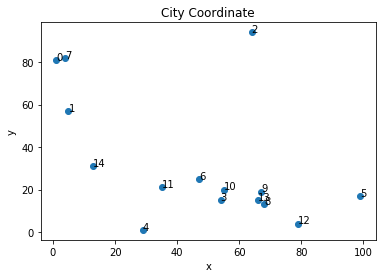

In [15]:
# 点坐标、距离矩阵
coord_generator = CoordinateProcess(num_cities=15, min_coord=1, max_coord=100)
coord_generator.plot_cities()
city_coord = coord_generator.coordinate
distance_matrix = coord_generator.distance_matrix

best path: [10, 4, 11, 12, 9, 5, 13, 8, 3, 1, 0, 2, 7, 14, 6, 10]
length of best path: 365.3770311191329
best path fitness: 0.2736898914901811


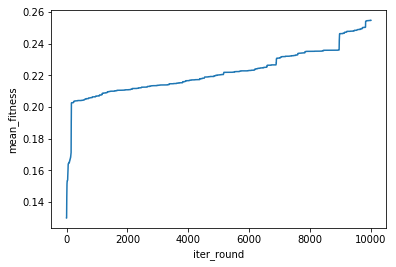

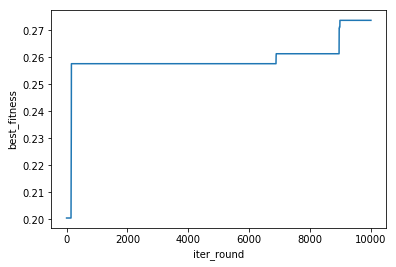

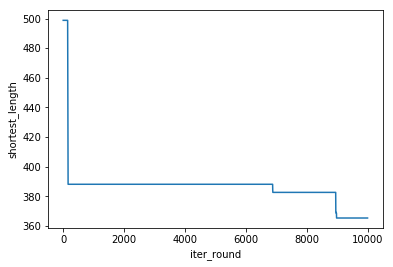

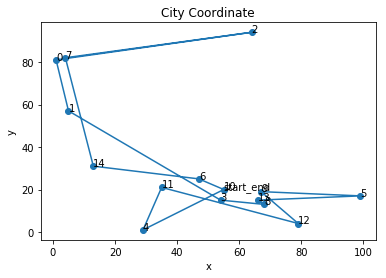

(None, None)

In [17]:
test_pso = PsoTsp(city_coord, distance_matrix,
                  partical_size=100, iter_round=1000, inertial_weight=0.9,alpha=0.4, beta=0.4)
test_pso.pso_engine()